In [1]:
import pandas as pd

DATA_FILE = '../../data/chimpanzees.csv'

In [2]:
df = pd.read_csv(DATA_FILE)
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


### Code 11.2

In [3]:
df['treatment'] = df['prosoc_left'] + 2 * df['condition']
df[['condition', 'prosoc_left', 'treatment']].drop_duplicates()

,condition,prosoc_left,treatment
0,0,0,0
2,0,1,1
36,1,0,2
38,1,1,3


### Explanation

|Treatment | Partner | Food |
|----------|---------|------|
| 0           | no       | right  |
| 1           | no       | left   |
| 2           | yes      | right  |
| 3           | yes      | left   |


In [4]:
df['actor'].drop_duplicates()

0      1
72     2
144    3
216    4
288    5
360    6
432    7
Name: actor, dtype: int64

## Model

\begin{align*}
    L_i & \sim \text{Binomial}(1, p_i) \\
    \log \frac{p_i}{1 - p_i} & = \alpha_{\text{actor}[i]} + \beta_{\text{treatment}[i]} \\
    \alpha_j & \sim \text{to be determined} \\
    \beta_j & \sim \text{to be determined}
\end{align*}

Here $L$ indicates the binary variable `pulled_left`; there are $7$ $\alpha$ `parameters`, one for each chimpanzee; there are $4$ `treatment` variables, one for each combination of the position of the pro-social option and the presence/absence of a partner. The variable $i$ is an index to the row of the data. Each row is associated with a specific actor and a specific treatment. What this model postulates is that the probability of pulling the left lever depends on both the actor and specific treatment condition.  

As a reminder, if $\text{logit}(p) = x$ then $p = \sigma(x)$, where 
$$
    \sigma(x) = \frac{1}{1 + e^{-x}}.
$$

## Priors for $\alpha$

The very first attempt consists of using a flat prior for $\alpha$.

\begin{align*}
    L_i & \sim \text{Binomial}(1, p_i) \\
    \log \frac{p_i}{1 - p_i} & = \alpha  \\
    \alpha & \sim \text{Normal}(0, \omega)
\end{align*}


In [5]:
import arviz as az
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy import stats
from scipy.special import expit as logistic

warnings.simplefilter(action="ignore", category=FutureWarning)

RANDOM_SEED = 1234567

az.style.use("arviz-darkgrid")

### Code 11.4 - 11.6

In [6]:
with pm.Model() as m_11_1:
    a = pm.Normal('a', mu=0, sigma=10)
    p = pm.Deterministic('p', pm.math.invlogit(a))
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=df['pulled_left'])
    
    prior_11_1 = pm.sample_prior_predictive(4000, random_seed=RANDOM_SEED)

In [7]:
prior_11_1

{'a': array([ -5.1462472 ,  -4.49554448,  17.34621467, ..., -13.09713758,
        -18.59217255,   1.67345857]),
 'p': array([5.78751927e-03, 1.10354630e-02, 9.99999971e-01, ...,
        2.05108912e-06, 8.42407183e-09, 8.42036394e-01]),
 'pulled_left': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 1, ..., 1, 1, 1]])}

In [8]:
with pm.Model() as m_11_1_base:
    a = pm.Normal('a', mu=0, sigma=1.5)
    p = pm.Deterministic('p', pm.math.invlogit(a))
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=df['pulled_left'])
    
    prior_11_1_base = pm.sample_prior_predictive(4000, random_seed=RANDOM_SEED)

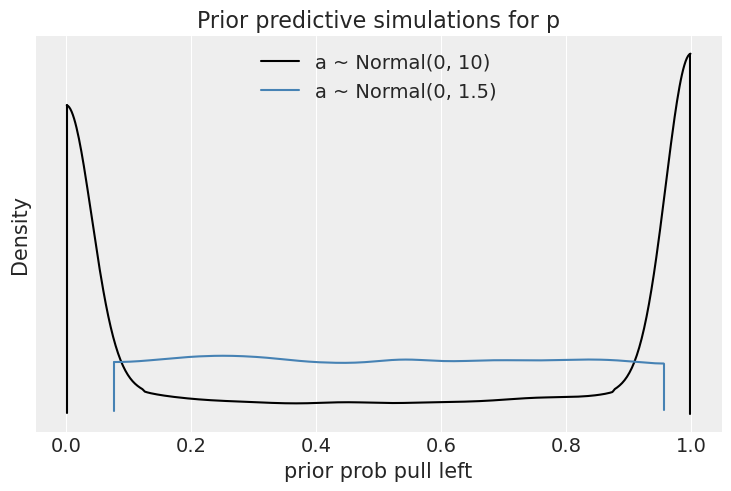

In [9]:
az.plot_density([prior_11_1['p'], prior_11_1_base['p']], 
                data_labels=['a ~ Normal(0, 10)', 'a ~ Normal(0, 1.5)'],
                colors=['k', 'steelblue'], 
                point_estimate=None);

plt.xlabel("prior prob pull left")
plt.ylabel("Density")
plt.title("Prior predictive simulations for p");

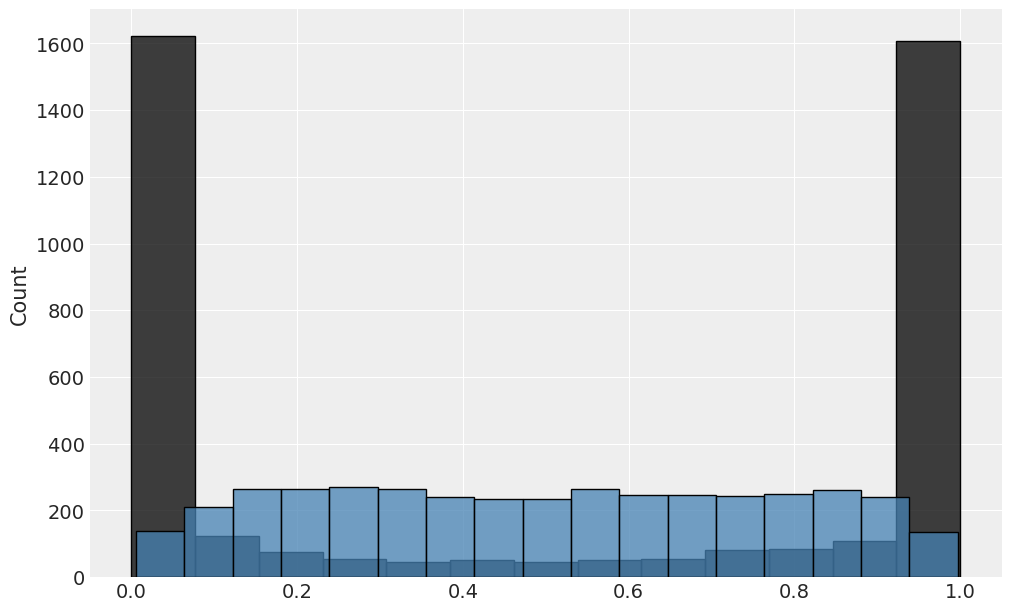

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.histplot(prior_11_1['p'], ax=ax, color='k');
sns.histplot(prior_11_1_base['p'], ax=ax, color='steelblue');

## Priors for the treatment effects

### Code 11.7

In [11]:
with pm.Model() as m_11_2:
    a = pm.Normal('a', mu=0, sigma=1.5)
    b = pm.Normal('b', mu=0, sigma=10, shape=df['treatment'].nunique())
    p = pm.Deterministic('p', pm.math.invlogit(a + b[df['treatment']]))
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=df['pulled_left'])
    
    prior_11_2 = pm.sample_prior_predictive(4000, random_seed=RANDOM_SEED)

In [12]:
prior_11_2['p'].shape

(4000, 504)

In [13]:
with pm.Model() as m_11_2_base:
    a = pm.Normal('a', mu=0, sigma=1.5)
    b = pm.Normal('b', mu=0, sigma=0.5, shape=df['treatment'].nunique())
    p = pm.Deterministic('p', pm.math.invlogit(a + b[df['treatment']]))
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=df['pulled_left'])
    
    prior_11_2_base = pm.sample_prior_predictive(4000, random_seed=RANDOM_SEED)

In [14]:
prior_11_2_base['p'].shape

(4000, 504)

In [15]:
idx_0 = df[df['treatment'] == 0].index
idx_1 = df[df['treatment'] == 1].index
idx_2 = df[df['treatment'] == 2].index
idx_3 = df[df['treatment'] == 3].index

prior_p_11_2 = [prior_11_2['p'][:, idx] for idx in [idx_0, idx_1, idx_2, idx_3]]
prior_p_11_2_base = [prior_11_2_base['p'][:, idx] for idx in [idx_0, idx_1, idx_2, idx_3]]

In [16]:
for prior_p in prior_p_11_2:
    print(prior_p.shape)

(4000, 126)
(4000, 126)
(4000, 126)
(4000, 126)


### Code 11.8

In [17]:
abs_diff_0_1 = np.abs(prior_p_11_2[0].T - prior_p_11_2[1].T)
abs_diff_0_1_base = np.abs(prior_p_11_2_base[0].T - prior_p_11_2_base[1].T)
abs_diff_0_1.shape, abs_diff_0_1_base.shape

((126, 4000), (126, 4000))

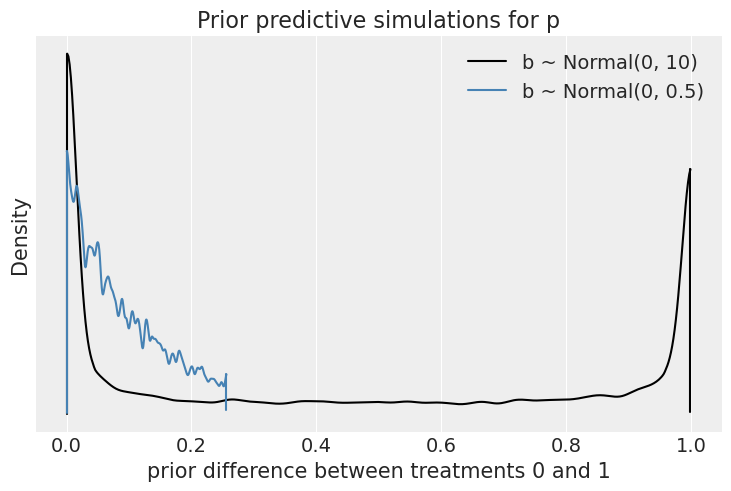

In [18]:
az.plot_density([abs_diff_0_1, abs_diff_0_1_base], 
                data_labels=['b ~ Normal(0, 10)', 'b ~ Normal(0, 0.5)'],
                colors=['k', 'steelblue'], 
                point_estimate=None);

plt.xlabel("prior difference between treatments 0 and 1")
plt.ylabel("Density")
plt.title("Prior predictive simulations for p");

### Code 11.9

In [19]:
abs_diff_0_1_base.mean()

0.09800027091330503

### Code 11.10

In [20]:
actor_ids, actors = pd.factorize(df['actor'])
treatment_ids, treatment = pd.factorize(df['treatment'])

In [21]:
with pm.Model() as m_11_4:
    a = pm.Normal('a', mu=0, sigma=1.5, shape=len(actors))
    b = pm.Normal('b', mu=0, sigma=0.5, shape=len(treatment))
    
    # This was taken verbatim from https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_11.ipynb
    # Not sure what this does
    actor_id = pm.intX(pm.Data('actor_id', actor_ids))
    treat_id = pm.intX(pm.Data('treat_id', treatment_ids))
    p = pm.Deterministic('p', pm.math.invlogit(a[actor_id] + b[treat_id]))
    
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=df['pulled_left'])
    
    trace_11_4 = pm.sample(2000, tune=2000, return_inferencedata=False, random_seed=RANDOM_SEED);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 7 seconds.


In [22]:
az.summary(trace_11_4, var_names=['a', 'b'], round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.44,0.33,-0.94,0.11,0.01,0.00,2832.63,3835.39,1.0
a[1],3.89,0.75,2.70,5.02,0.01,0.01,4781.78,4121.75,1.0
a[2],-0.74,0.34,-1.29,-0.21,0.01,0.00,2972.21,4293.90,1.0
a[3],-0.73,0.34,-1.27,-0.19,0.01,0.00,3053.81,4661.94,1.0
a[4],-0.44,0.33,-0.98,0.09,0.01,0.00,2749.37,3623.05,1.0
a[5],0.49,0.34,-0.07,1.01,0.01,0.00,2888.65,4389.85,1.0
a[6],1.97,0.42,1.29,2.64,0.01,0.01,3485.63,4892.55,1.0
b[0],-0.05,0.29,-0.50,0.41,0.01,0.00,2559.48,4197.58,1.0
b[1],0.47,0.29,0.01,0.92,0.01,0.00,2484.93,3775.58,1.0
b[2],-0.39,0.29,-0.84,0.08,0.01,0.00,2508.35,3853.09,1.0


## A Note on the columns in the summary

Modified from the Stan online reference (https://mc-stan.org/rstan/reference/Rhat.html)

The `R-hat` convergence diagnostic compares the between- and within-chain estimates for model parameters. If chains have not mixed well (i.e., the between- and within-chain estimates don't agree), R-hat is larger than 1. 

The `ess_bulk` is an estimate of the _Bulk Effective Sample Size (bulk-ESS)_. This is a useful measure for sampling efficiency in the bulk of the distribution (related e.g. to efficiency of mean and median estimates), and is well-defined even if the chains do not have finite mean or variance.

The `ess_tail` is an estimate of the _Tail Effective Sample Size (tail-ESS)_. This is a useful measure for sampling efficiency in the tails of the distribution.

**Stan Recommendation**

Both bulk-ESS and tail-ESS should be at least 100 (approximately) per Markov Chain in order to be reliable and indicate that estimates of respective posterior quantiles are reliable.

### More Details on the Estimation of $\hat{R}$ and Effective Sample Size

* Aki Vehtari, Andrew Gelman, Daniel Simpson, Bob Carpenter, and Paul-Christian Bürkner. Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC. https://arxiv.org/pdf/1903.08008.pdf

### Code 11.12

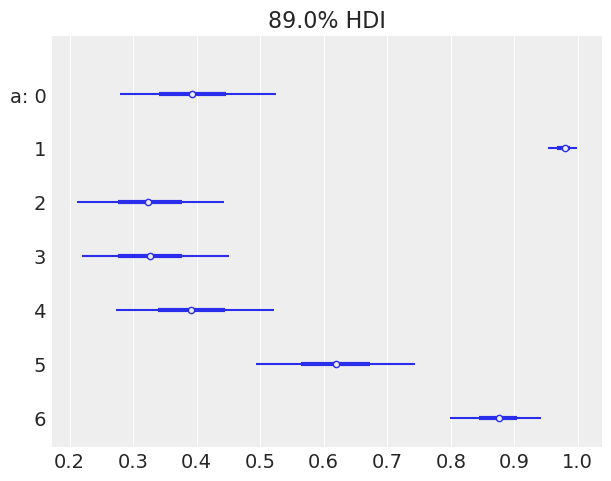

In [23]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


az.plot_forest(trace_11_4, var_names=['a'], transform=sigmoid, hdi_prob=0.89, combined=True);

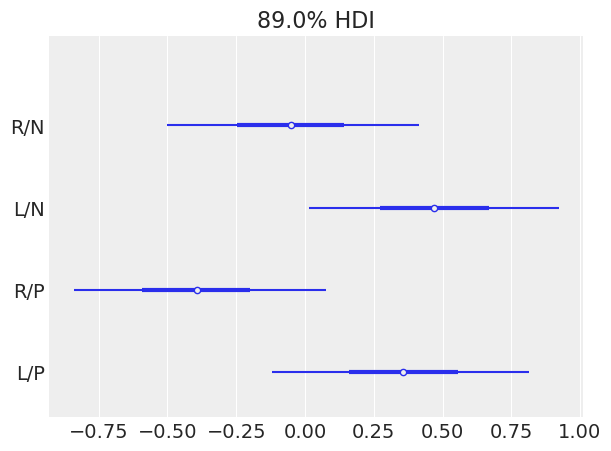

In [24]:
ax = az.plot_forest(trace_11_4, var_names=['b'], hdi_prob=0.89, combined=True);
ax[0].set_yticklabels(['L/P', 'R/P', 'L/N', 'R/N']);

In [25]:
trace_11_4['b'].shape

(8000, 4)

In [26]:
db13 = trace_11_4['b'][:, 0] - trace_11_4['b'][:, 2]
db24 = trace_11_4['b'][:, 1] - trace_11_4['b'][:, 3]

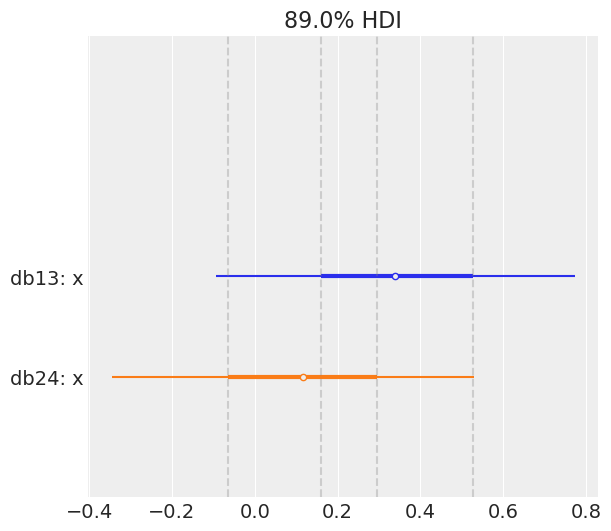

In [27]:
db13_50 = np.quantile(db13, [0.25, 0.75])
db24_50 = np.quantile(db24, [0.25, 0.75])

ax = az.plot_forest([db13, db24], model_names=["db13", "db24"], hdi_prob=0.89, combined=True);

ax[0].axvline(x=db13_50[0], linestyle='--', color='grey', alpha=0.3)
ax[0].axvline(x=db13_50[1], linestyle='--', color='grey', alpha=0.3)
ax[0].axvline(x=db24_50[0], linestyle='--', color='grey', alpha=0.3)
ax[0].axvline(x=db24_50[1], linestyle='--', color='grey', alpha=0.3)

### Code 11.15

In [28]:
pl = df.groupby(['actor', 'treatment'])['pulled_left'].agg('mean').unstack()
pl

treatment,0,1,2,3
actor,,,,
1,0.333333,0.500000,0.277778,0.555556
2,1.000000,1.000000,1.000000,1.000000
3,0.277778,0.611111,0.166667,0.333333
4,0.333333,0.500000,0.111111,0.444444
5,0.333333,0.555556,0.277778,0.500000
6,0.777778,0.611111,0.555556,0.611111
7,0.777778,0.833333,0.944444,1.000000


In [29]:
pl.stack().reset_index()

,actor,treatment,0
0,1,0,0.333333
1,1,1,0.500000
2,1,2,0.277778
3,1,3,0.555556
4,2,0,1.000000
5,2,1,1.000000
6,2,2,1.000000
7,2,3,1.000000
8,3,0,0.277778
9,3,1,0.611111


### Credit https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_11.ipynb

In [30]:
with m_11_4:
    pm.set_data({"actor_id": np.repeat(range(7), 4), "treat_id": list(range(4)) * 7})
    p_post = pm.sample_posterior_predictive(trace_11_4,
                                            random_seed=RANDOM_SEED, 
                                            var_names=['p'])['p']
p_mu = p_post.mean(0).reshape((7, 4))

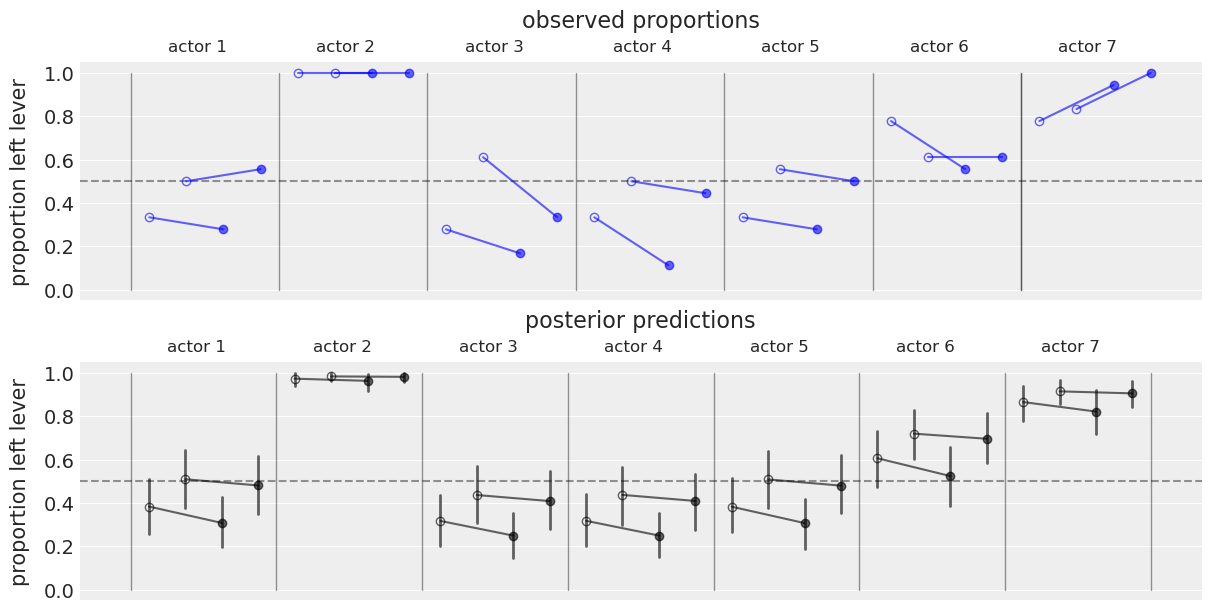

In [31]:
pl_val = pl.stack().values
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6))

alpha, xoff, yoff = 0.6, 0.3, 0.05

ax0.plot([7 * 4 - 0.5] * 2, [0, 1], c='k', alpha=0.4, lw=1)
ax0.axhline(0.5, ls='--', c='k', alpha=0.4)

for actor in range(1, 1 + len(actors)):
    ax0.plot(
        [actor * 4, actor * 4 + 2],
        [pl.loc[actor, 0], pl.loc[actor, 2]],
        '-',
        c='b',
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4 + 1, actor * 4 + 3],
        [pl.loc[actor, 1], pl.loc[actor, 3]],
        '-',
        c='b',
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4, actor * 4 + 1],
        [pl.loc[actor, 0], pl.loc[actor, 1]],
        'o',
        c='b',
        fillstyle='none',
        ms=6,
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4 + 2, actor * 4 + 3],
        [pl.loc[actor, 2], pl.loc[actor, 3]],
        'o',
        c='b',
        ms=6,
        alpha=alpha,
    )
    ax0.plot([actor * 4 - 0.5] * 2, [0, 1], c='k', alpha=0.4, lw=1)
    ax0.text(actor * 4 + 0.5, 1.1, f'actor {actor}', fontsize=12)
    if actor == 0:
        ax0.text(actor * 4 - xoff, pl.loc[actor, 0] - 2 * yoff, 'R/N')
        ax0.text(actor * 4 + 1 - xoff, pl.loc[actor, 1] + yoff, 'L/N')
        ax0.text(actor * 4 + 2 - xoff, pl.loc[actor, 2] - 2 * yoff, 'R/P')
        ax0.text(actor * 4 + 3 - xoff, pl.loc[actor, 3] + yoff, 'L/P')

ax0.set_xticks([])
ax0.set_ylabel('proportion left lever', labelpad=10)
ax0.set_title('observed proportions', pad=25)

ax1.plot([range(28), range(28)], az.hdi(p_post).T, 'k-', lw=2, alpha=alpha)
ax1.plot([7 * 4 - 0.5] * 2, [0, 1], c='k', alpha=0.4, lw=1)
ax1.axhline(0.5, ls='--', c='k', alpha=0.4)

for actor in range(len(actors)):
    ax1.plot(
        [actor * 4, actor * 4 + 2],
        [p_mu[actor, 0], p_mu[actor, 2]],
        '-',
        c='k',
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4 + 1, actor * 4 + 3],
        [p_mu[actor, 1], p_mu[actor, 3]],
        '-',
        c='k',
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4, actor * 4 + 1],
        [p_mu[actor, 0], p_mu[actor, 1]],
        'o',
        c='k',
        fillstyle='none',
        ms=6,
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4 + 2, actor * 4 + 3],
        [p_mu[actor, 2], p_mu[actor, 3]],
        'o',
        c='k',
        ms=6,
        alpha=alpha,
    )
    ax1.plot([actor * 4 - 0.5] * 2, [0, 1], c='k', alpha=0.4, lw=1)
    ax1.text(actor * 4 + 0.5, 1.1, f'actor {actor + 1}', fontsize=12)

ax1.set_xticks([])
ax1.set_ylabel('proportion left lever', labelpad=10)
ax1.set_title('posterior predictions', pad=25);

### Code 11.18

In [32]:
side = df['prosoc_left'].values # right = 0, left = 1
cond = df['condition'].values # no partner = 0, partner = 1

### Code 11.19

In [33]:
with pm.Model() as m_11_5:
    a = pm.Normal('a', mu=0, sigma=1.5, shape=df['actor'].nunique())
    bs = pm.Normal('bs', mu=0, sigma=0.5, shape=2)
    bc = pm.Normal('bc', mu=0, sigma=0.5, shape=2)
    
    p = pm.Deterministic('p', pm.math.invlogit(a[actor_ids] + bs[side] + bc[cond]))
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=df['pulled_left'])
    
    trace_11_5 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bc, bs, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.


In [34]:
trace_11_5['p'].shape

(8000, 504)

In [35]:
with m_11_4:
    pm.set_data({"actor_id": actor_ids, "treat_id": treatment_ids})
    trace_11_4 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [36]:
az.compare({'m11.4': trace_11_4, 'm11.5': trace_11_5}, ic='loo')

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m11.5,0,-265.248144,7.599845,0.000000,1.0,9.541919,0.000000,False,log
m11.4,1,-265.938750,8.341003,0.690606,0.0,9.465247,0.635209,False,log


In [37]:
az.compare({'m11.4': trace_11_4, 'm11.5': trace_11_5}, ic='waic')

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m11.5,0,-265.245371,7.597072,0.000000,1.0,9.541824,0.000000,False,log
m11.4,1,-265.932753,8.335006,0.687382,0.0,9.464668,0.635251,False,log


### Meaning of Columns

Taken verbatim from https://docs.pymc.io/notebooks/model_comparison.html


1. The index is the names of the models taken from the keys of the dictionary passed to compare(.).

2. `rank`, the ranking of the models starting from 0 (best model) to the number of models.

3. `loo`, the values of LOO (or WAIC). The DataFrame is always sorted from best LOO/WAIC to worst.

4. `p_loo`, the value of the penalization term. We can roughly think of this value as the estimated effective number of parameters (but do not take that too seriously).

5. `d_loo`, the relative difference between the value of LOO/WAIC for the top-ranked model and the value of LOO/WAIC for each model. For this reason we will always get a value of 0 for the first model.

6. `weight`, the weights assigned to each model. These weights can be loosely interpreted as the probability of each model being true (among the compared models) given the data.

7. `se`, the standard error for the LOO/WAIC computations. The standard error can be useful to assess the uncertainty of the LOO/WAIC estimates. By default these errors are computed using stacking.

8. `dse`, the standard errors of the difference between two values of LOO/WAIC. The same way that we can compute the standard error for each value of LOO/WAIC, we can compute the standard error of the differences between two values of LOO/WAIC. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about LOO/WAIC is correlated between models. This quantity is always 0 for the top-ranked model.

9. `warning`, If True the computation of LOO/WAIC may not be reliable.

10. `loo_scale`, the scale of the reported values. The default is the log scale as previously mentioned. Other options are deviance – this is the log-score multiplied by -2 (this reverts the order: a lower LOO/WAIC will be better) – and negative-log – this is the log-score multiplied by -1 (as with the deviance scale, a lower value is better).


### Code 11.23

This calculates the relative change in the odds of the left lever being pulled. Recall that the odds the left lever being pulled by an actor $\alpha$ under two different treatments $\beta_1$ and $\beta_2$ are given by:
\begin{align*}
    \log \frac{p_1}{1 - p_1} & = \alpha + \beta_1 \\
    \log \frac{p_2}{1 - p_2} & = \alpha + \beta_2.
\end{align*}
The relative odds $\frac{p_2}{1 - p_2} \div \frac{p_1}{1 - p_1}$ is $e^{\beta_2 - \beta_1}$.

In [38]:
np.mean(np.exp(trace_11_4['b'][:, 3] - trace_11_4['b'][:, 1]))

0.927202553198784